In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import matplotlib.patches as mpatches
numpy.random.seed(7)

In [ ]:
dataframe = pandas.read_csv('/content/drive/My Drive/Colab Notebooks/csv_covid_3k_dataset_timeseries_12_5_20.csv',header=None)

dataset = dataframe.values
dataset = dataset.astype('float32')

print('Dataset Shape: ', numpy.shape(dataset))

#dt=numpy.reshape(dataset,(1,9552))   # 330 x 12
#numpy.shape(dt)
#dataset=numpy.transpose(dt,axes=None);
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)


train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

Dataset Shape:  (3067, 12)
2453 614


## In this section, I made dataset shaped into 12 batch per target

In [ ]:
def create_dataset(dataset, look_back, btch):  #This function takes 12 patients and labels 12+ith patient - (12x12)
    dataX, dataY = [], []
    z=0
    inc=1
    for i in range(0,len(dataset)-look_back,inc):
        a = dataset[i:(i+look_back)]
        
        dataX.append(numpy.reshape(a,(btch,12)))
        dataY.append(dataset[i+look_back])
        z+=1
    return numpy.array(dataX), numpy.array(dataY)
 
btch=12    
look_back = 12
trainX, trainY = create_dataset(train, look_back, btch)
testX, testY = create_dataset(test, look_back, btch)

trainX = numpy.reshape(trainX, (trainX.shape[0], btch,12))
testX = numpy.reshape(testX, (testX.shape[0], btch, 12))
print(len(trainX), len(testX))



In [ ]:


#Creating Model

model = tf.keras.Sequential()
model.add(layers.LSTM(500,activation='relu', input_shape=(btch, 12))) # maybe i am unable to create a good model. low idea on LSTM

model.add(layers.Dense(250))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(150))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(12)) #softmax
model.compile(loss='mean_squared_error', optimizer='adam')
history=model.fit(trainX, trainY, validation_split=0.30,epochs=300, batch_size=70, verbose=2)

plt.plot(history.history['loss'])
plt.plot(numpy.array(history.history['val_loss']))
plt.title('Model loss')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

Train Score: 0.02 RMSE
Test Score: 0.04 RMSE


Text(0, 0.5, 'Mutation Rate in %')

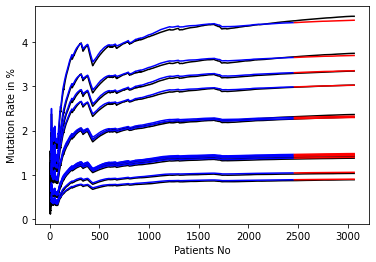

In [ ]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)


# invert predictions

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)

#calculating error

trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

dset=scaler.inverse_transform(dataset)
# 624+148=772
# shift train predictions for plotting
trainPredictPlot = numpy.empty([len(trainX)+12,12])
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[btch-1:len(trainX)+btch-1] = trainPredict +.02
# shift test predictions for plotting
testPredictPlot = numpy.empty([len(dataset),12])
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainX)+btch*2:len(trainX)+len(testY)+btch*2] =  testPredict +.02
# plot baseline and predictions
plt.plot(dset,color="black")
plt.plot(trainPredictPlot,color="blue")
plt.plot(testPredictPlot,color="red")
# plt.savefig('Raw_data_covid.png',dpi=300)
plt.xlabel('Patients No')
plt.ylabel('Mutation Rate in %')
# plt.show()

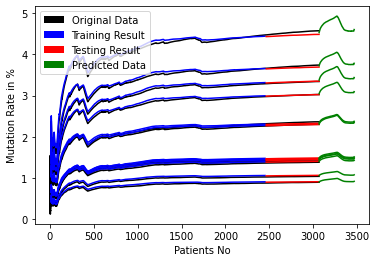

In [ ]:
PD=[]
Dt=testX[601]
# Dt=dataset[3066]
# Dt=scaler.fit_transform(ttf)
# PD.append(Dt[len(testY)-btch:len(testY)])                   #taking last element from test prediction
postData=numpy.array(Dt)
postData=numpy.reshape(postData, (1,btch,12))
#print(postData)
futureData=[]
futureData.append(postData)
temp=[]
result=[]
fuData=[]
futNo=100*4
for i in range(futNo):
    
    future = model.predict(futureData[i])
    postData=numpy.array(future)
    if(i<200):
        postData=postData  + zt[i%200] # tried to tune data - not working
    else:
        postData=postData  + ztv2[i%200]
#     postData=numpy.reshape(postData, (1,1,12))
    
    ftd=numpy.empty([btch,12])
    nk=numpy.array(futureData[i])
    ftd[0:btch-1,0:12]=nk[0,1:btch]
#     print(numpy.shape(postData))
    ftd[btch-1,:]=postData[:]
    
    temp=numpy.reshape(ftd,(1,btch,12))
#     print(numpy.shape(temp))
    futureData.append(temp)
    
    
    postData=numpy.reshape(postData, (1,1,12))
    result.append(postData)
    
fuData=numpy.reshape(result,(futNo,12))


trainPredictPlot = numpy.empty([len(trainX)+12,12])
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[btch-1:len(trainX)+btch-1] = trainPredict +.03
# shift test predictions for plotting
testPredictPlot = numpy.empty([len(dataset),12])
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainX)+btch*2:len(trainX)+len(testY)+btch*2] =  testPredict +.02


bk=len(dataset); # total data
now=futNo; # total predicted data


# futurePredictPlot = numpy.empty(bk+now,:)

futurePredictPlot=numpy.empty([bk+now,12])
futurePredictPlot[:, :] = numpy.nan
futurePredictPlot[bk:(bk+now), 0:12] = scaler.inverse_transform(fuData)

# plot baseline and predictions

plt.plot(dset,color="black",label='Original Data')
plt.plot(trainPredictPlot,color="blue",label='Training Result')
plt.plot(testPredictPlot,color="red",label='Testing Result')
plt.plot(futurePredictPlot,color="green",label='Predicted Data')



red_patch = mpatches.Patch(color='black', label='Original Data',linewidth=0)
red_patch1 = mpatches.Patch(color='blue', label='Training Result',linewidth=0)
red_patch2= mpatches.Patch(color='red', label='Testing Result',linewidth=0)
red_patch3 = mpatches.Patch(color='green', label='Predicted Data',linewidth=0)
plt.legend(handles=[red_patch,red_patch1,red_patch2,red_patch3])
plt.xlabel('Patients No')
plt.ylabel('Mutation Rate in %')
# plt.savefig('predictioin_covid_14_05_20.png',dpi=300)
plt.show()

In [ ]:
zt=numpy.empty([200,12])
ztv2=numpy.empty([200,12])
for i in range(0,200):
    zt[i]=testY[i+5]-testY[i] + .0119
zt[0]
for i in range(0,200):
     ztv2[i]=fuData[i+5]-fuData[i] + .0099
ztv2[0]

array([0.02173802, 0.02013555, 0.0212492 , 0.02238038, 0.02256217,
       0.0216141 , 0.0202659 , 0.02051428, 0.02109053, 0.02103176,
       0.02165296, 0.01970824])

In [ ]:
(ztv2)

array([[1.43253407e-02, 1.37078962e-02, 1.40416226e-02, ...,
        1.41419373e-02, 1.42809353e-02, 1.35064921e-02],
       [1.35957203e-02, 1.30692325e-02, 1.32543645e-02, ...,
        1.30732260e-02, 1.33468709e-02, 1.26115880e-02],
       [1.29887066e-02, 1.22950873e-02, 1.28612719e-02, ...,
        1.26894913e-02, 1.29193268e-02, 1.22457347e-02],
       ...,
       [1.28497132e+16, 1.15924002e+16, 1.23855046e+16, ...,
        1.24986598e+16, 1.23219884e+16, 1.10935226e+16],
       [1.75494726e+16, 1.58322974e+16, 1.69154839e+16, ...,
        1.70700254e+16, 1.68287255e+16, 1.51509567e+16],
       [2.39681595e+16, 2.16229355e+16, 2.31022812e+16, ...,
        2.33133488e+16, 2.29838002e+16, 2.06923836e+16]])

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
# print(model.summary())

In [ ]:

fig=plt.plot(dset,color="black",label='Original Data')
plt.plot(trainPredictPlot,color="blue",label='Training Result')
plt.plot(testPredictPlot,color="red",label='Testing Result')
plt.plot(futurePredictPlot,color="green",label='Predicted Data')

red_patch = mpatches.Patch(color='black', label='Original Data',linewidth=0)
red_patch1 = mpatches.Patch(color='blue', label='Training Result',linewidth=0)
red_patch2= mpatches.Patch(color='red', label='Testing Result',linewidth=0)
red_patch3 = mpatches.Patch(color='green', label='Predicted Data',linewidth=0)
plt.legend(handles=[red_patch,red_patch1,red_patch2,red_patch3],loc=(1.01,.71))
plt.xlabel('Patients No')
plt.ylabel('Mutation Rate in %')
plt.ylim(0,5)
# plt.yticks(numpy.arange(0,5,1))
# yticks((0,1,2,3,4),(0,1,2,3,4,5))
plt.savefig('predictioin_covid_14_05_20.png',dpi=500)
plt.show()


In [ ]:
fig = pyplot.figure(figsize=(3,3))
ax  = fig.add_subplot(111)